# Redes Transformers

Foram originalmente criadas para lidar com tarefas de PLN (Processamento de Linguagem Natural), usando o mecanismo de atenção

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfkl
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics

Vamos começar criando uma camada MultiHeadAttention do zero.

In [12]:
class DotProductAttention(tfkl.Layer):

  def __init__(self, **kwargs):
    super(DotProductAttention, self).__init__(**kwargs)

  def call(self, queries, keys, values, dk, mask=None):
    scores = tf.matmul(queries, keys, transpose_b=True) / tf.math.sqrt(tf.cast(dk, tf.float32))
    if mask is not None:
        scores += -1e9 * mask
    weights = tf.nn.softmax(scores)
    return tf.matmul(weights, values)

In [3]:
class MultiHeadAttention(tfkl.Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.attention = DotProductAttention()
        self.heads = h 
        self.d_k = d_k  
        self.d_v = d_v 
        self.W_q = tfkl.Dense(d_k)  
        self.W_k = tfkl.Dense(d_k) 
        self.W_v = tfkl.Dense(d_v) 
        self.W_o = tfkl.Dense(d_model)

    def reshape_tensor(self, x, heads, flag):
      if flag:
          # Tensor shape after reshaping and transposing: (batch_size, heads, seq_length, -1)
          x = tf.reshape(x, shape=(tf.shape(x)[0], tf.shape(x)[1], heads, -1))
          x = tf.transpose(x, perm=(0, 2, 1, 3))
      else:
          # Reverting the reshaping and transposing operations: (batch_size, seq_length, d_model)
          x = tf.transpose(x, perm=(0, 2, 1, 3))
          x = tf.reshape(x, shape=(tf.shape(x)[0], tf.shape(x)[1], -1))
      return x
    
    def call(self, queries, keys, values, mask=None):
      # shape de entrada: (batch_size, input_seq_length, d_model)
      q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)
      # shape: (batch_size, heads, input_seq_length, -1)

      k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
      # shape: (batch_size, heads, input_seq_length, -1)

      v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
      # shape: (batch_size, heads, input_seq_length, -1)

      # Compute the multi-head attention output using the reshaped queries, keys and values
      o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_k, mask)
      # shape: (batch_size, heads, input_seq_length, -1)

      # Rearrange back the output into concatenated form
      output = self.reshape_tensor(o_reshaped, self.heads, False)
      # shape: (batch_size, input_seq_length, d_v)

      #shape: (batch_size, input_seq_length, d_model)
      return self.W_o(output)
          

In [15]:
h = 8
d_k = 64
d_v = 64
d_model = 512
batch_size = 64
input_seq_length = 5

queries = np.random.random((batch_size, input_seq_length, d_k))
keys = np.random.random((batch_size, input_seq_length, d_k))
values = np.random.random((batch_size, input_seq_length, d_v))

multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)

print(multihead_attention(queries, keys, values).shape)

(64, 5, 512)


Vamos usar um dataset que mostra 2 possíveis defeitos de um motor baseado na leitura de um determinado sensor. Parte do UCR Time Series Database

In [16]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

In [17]:
root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

Pequena análise de dados para saber com o que estamos lidando

In [36]:
print(f'{x_train.shape[0]} dados de treino e {x_test.shape[0]} dados de teste')
print(f'shape dos dados de treino = {x_train.shape} e de teste = {x_test.shape}')

3601 dados de treino e 1320 dados de teste
shape dos dados de treino = (3601, 500, 1) e de teste = (1320, 500, 1)


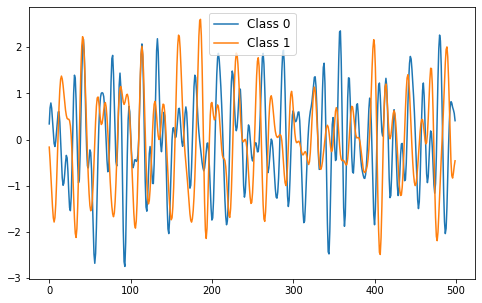

In [19]:
plt.figure(figsize=[8,5])
plt.plot(x_train[y_train == 0][0], label='Class 0')
plt.plot(x_train[y_train == 1][0], label='Class 1')
plt.legend(loc='upper center', fontsize=12)
plt.show()

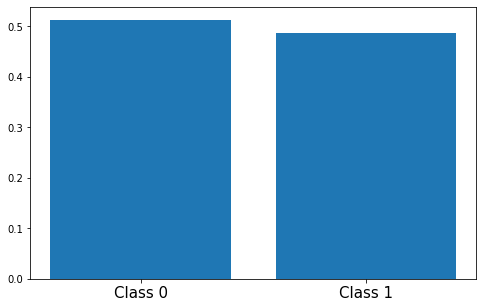

In [20]:
n1_train = np.count_nonzero(y_train)
n0_train = y_train.shape[0] - n1_train

plt.figure(figsize=[8,5])
plt.bar(range(2), [n0_train/y_train.shape[0], n1_train/y_train.shape[0]], tick_label=['Class 0', 'Class 1'])
plt.xticks(fontsize=15)
plt.show()

In [21]:
print(f'media de um exemplo = {np.mean(x_train[5])}')
print(f'desvio padrão de um exemplo = {np.std(x_train[5])}')

media de um exemplo = 1.1855800039484165e-09
desvio padrão de um exemplo = 0.9989994992415149


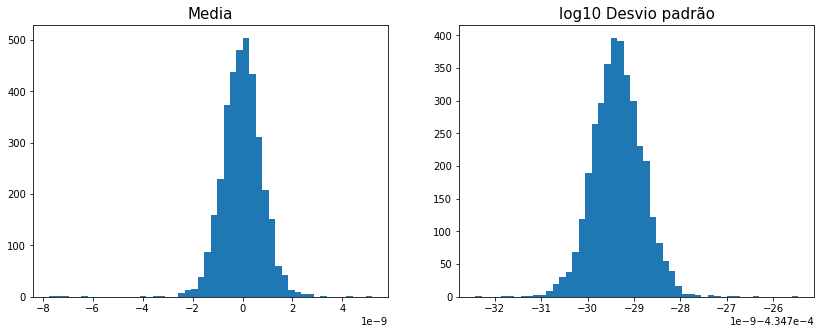

In [22]:
f, ax = plt.subplots(1, 2, figsize=[14,5])
ax[0].hist(np.mean(x_train, 1), 50)
ax[0].set_title('Media', fontsize=15)

ax[1].hist(np.log10(np.std(x_train, 1)), 50)
ax[1].set_title('log10 Desvio padrão', fontsize=15)
plt.show()

Criar uma rede transformer. Como não estamos fazendo um modelo de tradução e sim de classificação, não precisamos do decoder

In [23]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = tfkl.LayerNormalization(epsilon=1e-6)(inputs)
    x = tfkl.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = tfkl.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfkl.LayerNormalization(epsilon=1e-6)(res)
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu")(x)
        x = tfkl.Dropout(mlp_dropout)(x)
    outputs = tfkl.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [24]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=32,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 500, 1)      2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention_5 (MultiH  (None, 500, 1)      7169        ['layer_normalization[0][0]',    
 eadAttention)                                                    'layer_normalization[0][0]']    
                                                                                              

In [25]:
callbacks = [keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/200
51/51 [==============================] - 32s 460ms/step - loss: 0.9710 - accuracy: 0.5034 - val_loss: 0.7392 - val_accuracy: 0.5263
Epoch 2/200
51/51 [==============================] - 24s 469ms/step - loss: 0.7802 - accuracy: 0.5426 - val_loss: 0.6773 - val_accuracy: 0.6094
Epoch 3/200
51/51 [==============================] - 24s 467ms/step - loss: 0.7159 - accuracy: 0.5861 - val_loss: 0.6363 - val_accuracy: 0.6288
Epoch 4/200
51/51 [==============================] - 24s 476ms/step - loss: 0.6646 - accuracy: 0.6398 - val_loss: 0.6297 - val_accuracy: 0.6288
Epoch 5/200
51/51 [==============================] - 25s 481ms/step - loss: 0.6390 - accuracy: 0.6500 - val_loss: 0.5928 - val_accuracy: 0.6565
Epoch 6/200
51/51 [==============================] - 25s 487ms/step - loss: 0.6159 - accuracy: 0.6636 - val_loss: 0.5793 - val_accuracy: 0.6787
Epoch 7/200
51/51 [==============================] - 25s 497ms/step - loss: 0.5900 - accuracy: 0.6827 - val_loss: 0.5642 - val_accuracy:

### Métricas

Algumas métricas de classificação são:

- Acurácia (importante saber se o dataset está balanceado
- Receiver Operating Characteristic (ROC) curve e área sob a curva (AUC)
- Precision-Recall curve e AUC
- F1 score, definido como a média harmônica entre precision e recall: $f_1 = 2\times\frac{P\cdot R}{P+R}$
- Matriz de confusão

In [26]:
model.evaluate(x_test, y_test, verbose=1)

42/42 [==============================] - 3s 74ms/step - loss: 0.3174 - accuracy: 0.8561


[0.31739428639411926, 0.8560606241226196]

In [27]:
preds = model.predict(x_test)

42/42 [==============================] - 3s 73ms/step


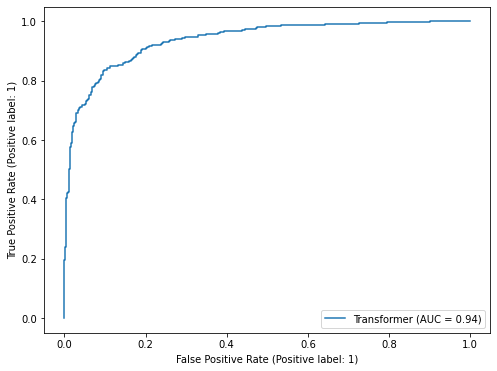

In [32]:
f = plt.figure(figsize=[8,6])
plot = sk_metrics.RocCurveDisplay.from_predictions(y_test, preds, name='Transformer', ax=f.gca())

In [35]:
rec, prec, _ = sk_metrics.precision_recall_curve(y_test, preds)

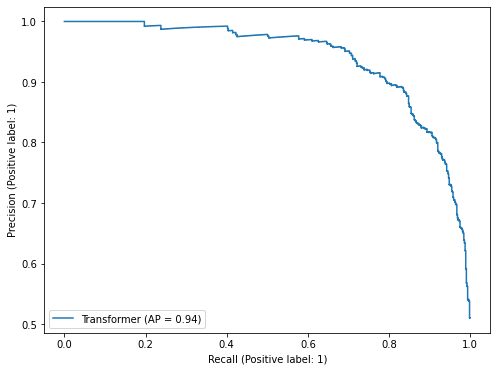

In [34]:
f = plt.figure(figsize=[8,6])
plot = sk_metrics.PrecisionRecallDisplay.from_predictions(y_test, preds, name='Transformer', ax=f.gca())

In [58]:
print(f'F1 score é {sk_metrics.f1_score(y_test, preds // 0.5)}')

F1 score é 0.85202492211838


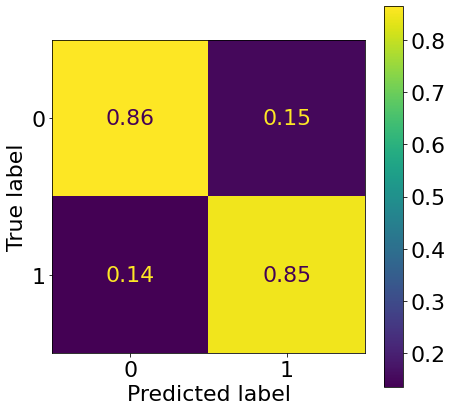

In [70]:
pred_classes = preds // 0.5
font = {'family' : 'times',
    'weight' : 'normal',
    'size'   : 22}
plt.rc('font', **font)
f, ax = plt.subplots(figsize=[7,7])

plot = sk_metrics.ConfusionMatrixDisplay.from_predictions(y_test, pred_classes, ax=ax, normalize='pred')